In [1]:
import pandas as pd
import numpy as np
import keras
import crested
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42  
matplotlib.rcParams["ps.fonttype"] = 42  
from pathlib import Path
import anndata

from scoring_utils import *

2025-03-20 14:41:15.080019: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 14:41:15.121599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 14:41:18.878187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [2]:
DATA_DIR ="../../../crested_data/Figure_5/"

# Load mm10 and hg38 genome

This notebook requires an mm10 and hg38 fasta file and an mm10 and hg38 chromosome sizes file. You can download that here for example: https://hgdownload.soe.ucsc.edu/downloads.html 
Once downloaded, we load them to the notebook.

In [3]:
genome_dir = "../../../mouse/biccn/"
genome_fasta = f"{genome_dir}mm10.fa"
genome_chrom_sizes  = f"{genome_dir}mm10.chrom.sizes" 

In [4]:
genome = crested.Genome(genome_fasta, genome_chrom_sizes)
crested.register_genome(genome)

2025-03-20T14:41:30.800166+0100 INFO Genome mm10 registered.


In [5]:
genome_mm = "../../../mouse/biccn/mm10.fa"
genome_hg = "../../../human/genome/hg38.fa"

In [6]:
import pysam

pysam_mm = pysam.FastaFile(genome_mm)
pysam_hg = pysam.FastaFile(genome_hg)

# Load enhancer data

In [7]:
df = pd.read_csv(f'{DATA_DIR}/data/biccn_enhancers.csv')
df

,old_idx,chrom,start,end,name,target_ct,second_target_ct,specificity,strength,enhancerID,species
0,9,chr1,46868072,46868423,chr1:46868072-46868423,L6_IT_Car3,NaN,On-Target,strong,AiE2051m,mouse
1,18,chr1,81508154,81508487,chr1:81508154-81508487,SstChodl,NaN,On-Target,strong,AiE0465m,mouse
2,19,chr1,90560790,90561290,chr1:90560790-90561290,Sncg,NaN,On-Target,strong,AiE0492m,mouse
3,21,chr1,120215946,120216285,chr1:120215946-120216285,L5ET,NaN,On-Target,strong,AiE0462m,mouse
4,25,chr1,126153519,126154399,chr1:126153519-126154399,L5_6NP,NaN,On-Target,weak,AiE2443m,mouse
...,...,...,...,...,...,...,...,...,...,...,...
166,667,chr8,56293639,56294037,chr8:56293639-56294037,Sst,SstChodl,On-Target,weak,AiE0529h,human
167,672,chr9,81717533,81717734,chr9:81717533-81717734,Oligo,NaN,On-Target,weak,AiE0410h,human
168,673,chr9,123741899,123742461,chr9:123741899-123742461,Astro,NaN,On-Target,weak,AiE0385h,human
169,674,chr9,128374068,128374662,chr9:128374068-128374662,Oligo,NaN,On-Target,strong,AiE0395h,human


## One-hot encode sequences

We will embed enhancers in zero-padded background sequences.

In [8]:
seq_len=2114
hot_encoding_table = get_hot_encoding_table()
# One-hot encode the sequences and concatenate the results
seqs_one_hot = one_hot_encode_sequences(df, seq_len, pysam_mm, pysam_hg, hot_encoding_table)

# Check the shape of the resulting concatenated array
print(seqs_one_hot.shape)

100%|██████████| 49/49 [00:00<00:00, 13250.86it/s]

(171, 2114, 4)


# Load models and make predictions

In [9]:
adata = anndata.read_h5ad(f"{DATA_DIR}data/mouse_biccn_data_specific.h5ad")

In [10]:
# DeepBICCN2 model
model_path =f"{DATA_DIR}models/deepbiccn2_ft.keras"
model = keras.models.load_model(
    model_path, compile=False
)

2025-03-20 14:41:32.468353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78790 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:e4:00.0, compute capability: 9.0


In [11]:
# Double finetuned Borzoi model to mouse cortex data
model_path =f"{DATA_DIR}models/borzoi_ft_consensus_ft_specific.keras"
model_borzoi_ft = keras.models.load_model(
    model_path, compile=False
)

## Load Borzoi
To compare against the orignal Borzoi (Linder et al., 2025), we can load it from through CREsted.

In [12]:
model_path, output_names = crested.get_model('Borzoi_mouse_rep0')
model_borzoi = keras.models.load_model(model_path)

In [13]:
# We map the DeepBICCN2 classes to the Borzoi classes
borzoi_mapping = {
    'Astro':'ATAC:ASCG',       # Astrocytes, grey matter
    'Endo': 'ATAC:VEC',        # Vascular endothelial cells
    'L2_3IT': 'ATAC:ITL23GL1', # Excitatory neurons, Cortex L2/3
    'L5ET':'ATAC:PTGL5',       # Excitatory neurons, Cortex PT
    'L5IT':'ATAC:ITL5GL1',     # Excitatory neurons, Cortex L5
    'L5_6NP':'ATAC:NPGL5',     # Excitatory neurons, Cortex NP
    'L6_CT':'ATAC:CTGL6',      # Excitatory neurons, Cortex CT
    'L6IT':'ATAC:ITL6GL1',     # Excitatory neurons, Cortex L5
    'L6b': 'ATAC:L6bGL1',      # Excitatory neurons, Cortex L6b
    'Lamp5':'ATAC:LAMGA2',     # CGE-derived neurogliaform cells, Lamp5 - Cortex
    'Micro-PVM':'ATAC:MGL',    # Microglia
    'OPC': 'ATAC:OPC',         # Oligodendrocytes precursor cells
    'Oligo': 'ATAC:MOL',       # Mature oligodendrocytes
    'Pvalb':'ATAC:PVGA1',      # MGE-derived neurogliaform cells, Pvalb
    'Sncg': 'ATAC:VIPGA2',     # CGE-derived neurogliaform cells, Sncg (maybe)
    'Sst':'ATAC:SSTGA1',       # MGE-derived neurogliaform cells, Sst
    'SstChodl': 'ATAC:SSTGA10',     # MGE-derived neurogliaform cells, Chodl (maybe)
    'VLMC': 'ATAC:VLMC1',     # Vascular and leptomeningeal cells
    'Vip': 'ATAC:VIPGA1'       # CGE-derived neurogliaform cells, Vip
} 

In [14]:
# We load the mouse target classes
targets_file = f"{DATA_DIR}data/targets_bor_mouse.txt"
targets = pd.read_csv(targets_file, sep = '\t', index_col = 0)
targets_dnase = targets[targets['description'].str.startswith('DNASE') ]
targets_atac = targets[targets['description'].str.startswith('ATAC')]

In [15]:
target_idcs=[]
for target in list(borzoi_mapping.values()):
    if target:
        idx = np.where(targets['description'] == target)[0][0]
        target_idcs.append(idx)
target_idcs

[958,
 1015,
 1054,
 982,
 1059,
 1113,
 1035,
 1062,
 1069,
 1077,
 1089,
 974,
 1090,
 986,
 1017,
 997,
 998,
 1020,
 1016]

In [16]:
# Get one hot encoded sequences for entire Borzoi input for the enhancers
seqs_one_hot_padded=np.zeros((171, 524288, 4))

for idx, row in df.iterrows():
    chrom = row['chrom']
    start = row['start']
    end = row['end']
    species = row['species']

    seq_len = 524288
    center = (start+end)//2
    seq_start, seq_end = center-seq_len//2, center+seq_len//2

    if species=='mouse':
        seq = pysam_mm.fetch(chrom, seq_start, seq_end)
    else:
        seq = pysam_hg.fetch(chrom, seq_start, seq_end)
    seq_1hot = crested.utils.one_hot_encode_sequence(seq)[0]
    seqs_one_hot_padded[idx]=seq_1hot

## Model predictions on enhancer set

In [17]:
model_names = ['DeepBICCN2','Borzoi (double-finetuned)','Base Borzoi']
models = [model, model_borzoi_ft, model_borzoi]

### DeepBICCN2 preds

In [18]:
all_preds = []

preds = crested.tl.predict(seqs_one_hot, model)
all_preds.append(preds)

I0000 00:00:1742478107.717975 3881370 service.cc:145] XLA service 0x7fd758002ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742478107.718007 3881370 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-03-20 14:41:47.735338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-20 14:41:47.825397: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step


I0000 00:00:1742478108.560623 3881370 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Borzoi double finetuned preds

In [19]:
# This model takes in 2048 bp sequences so we shorten the input a bit from the 2114 bp.
preds = crested.tl.predict(seqs_one_hot[:,33:-33], model_borzoi_ft)
all_preds.append(preds)

I0000 00:00:1742478110.659432 3881474 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 4 bytes spill stores, 4 bytes spill loads



171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


### Borzoi preds

In [20]:
borzoi_preds=[]
for s in tqdm(seqs_one_hot_padded):
    p = model_borzoi(np.expand_dims(s,0)).numpy()
    borzoi_preds.append(p)
borzoi_preds=np.array(borzoi_preds)

100%|██████████| 171/171 [00:23<00:00,  7.18it/s]


In [21]:
borzoi_preds=borzoi_preds.squeeze(axis=1)

In [22]:
# Only keep mean predictions for the center 1000 bp
borzoi_preds_mean = np.zeros((171,19))
for i, p in enumerate(borzoi_preds):
    p = p[:,target_idcs]
    tmp = []
    for j in range(len(target_idcs)):
        tmp.append(np.sum(p[3056:3088, j]))
    borzoi_preds_mean[i] = tmp

In [23]:
all_preds.append(borzoi_preds_mean)

In [24]:
classes = np.array(['Astro', 'Endo', 'L2_3IT', 'L5ET', 'L5IT', 'L5_6NP', 'L6CT',
       'L6IT', 'L6b', 'Lamp5', 'Micro_PVM', 'OPC', 'Oligo', 'Pvalb',
       'Sncg', 'Sst', 'SstChodl', 'VLMC', 'Vip'])
classes

array(['Astro', 'Endo', 'L2_3IT', 'L5ET', 'L5IT', 'L5_6NP', 'L6CT',
       'L6IT', 'L6b', 'Lamp5', 'Micro_PVM', 'OPC', 'Oligo', 'Pvalb',
       'Sncg', 'Sst', 'SstChodl', 'VLMC', 'Vip'], dtype='<U9')

## Mapping model classes to enhancer annotation

We need to manually map the cell types from the enhancer set to those in the dataset. We just make a dictionary with key the dataframe cell type and value the corresponding cell type from the model.

In [25]:
df_to_class_mapping_mm = {
    'Astro': 'Astro',
    'Endo': 'Endo',
    'L2_3IT': 'L2_3IT',
    'L5IT': 'L5IT',
    'L5ET': 'L5ET',
    'L5_6NP': 'L5_6NP',
    'L6CT': 'L6CT',
    'L6IT': 'L6IT',
    'L6b': 'L6b',
    'Lamp5': 'Lamp5',
    'Micro_PVM': 'Micro_PVM',
    'OPC': 'OPC',
    'Oligo': 'Oligo',
    'Pvalb': 'Pvalb',
    'Sncg': 'Sncg',
    'Sst': 'Sst',
    'SstChodl': 'SstChodl',
    'VLMC': 'VLMC',
    'Vip': 'Vip',
    'L4IT': 'L5IT',
    'L6_IT_Car3': 'L6IT',
    'Lamp5_Lhx6': 'Lamp5',
    'Pvalb_Chc': 'Pvalb', 
}

In [26]:
# Replace values in 'target_ct' and 'second_target_ct' using the mapping dictionary
df['target_ct'] = df['target_ct'].map(df_to_class_mapping_mm)
df['second_target_ct'] = df['second_target_ct'].map(df_to_class_mapping_mm)

In [27]:
df.iloc[117]

old_idx                                  513
chrom                                   chr9
start                              104691310
end                                104691762
name                chr9:104691310-104691762
target_ct                               L6IT
second_target_ct                         NaN
specificity                        On-Target
strength                              strong
enhancerID                          AiE2596m
species                                mouse
Name: 117, dtype: object

# Binary scoring of models
We can first do easy scoring of regions and assing the predicted cell type just as the maximal prediction per region.

In [28]:
prediction_dict = {}

for i in range(len(seqs_one_hot)):
    prediction_dict[df.iloc[i]['enhancerID']] = {}
    for j, pred in enumerate(all_preds):
        prediction_dict[df.iloc[i]['enhancerID']][model_names[j]] = classes[np.argmax(pred[i])]

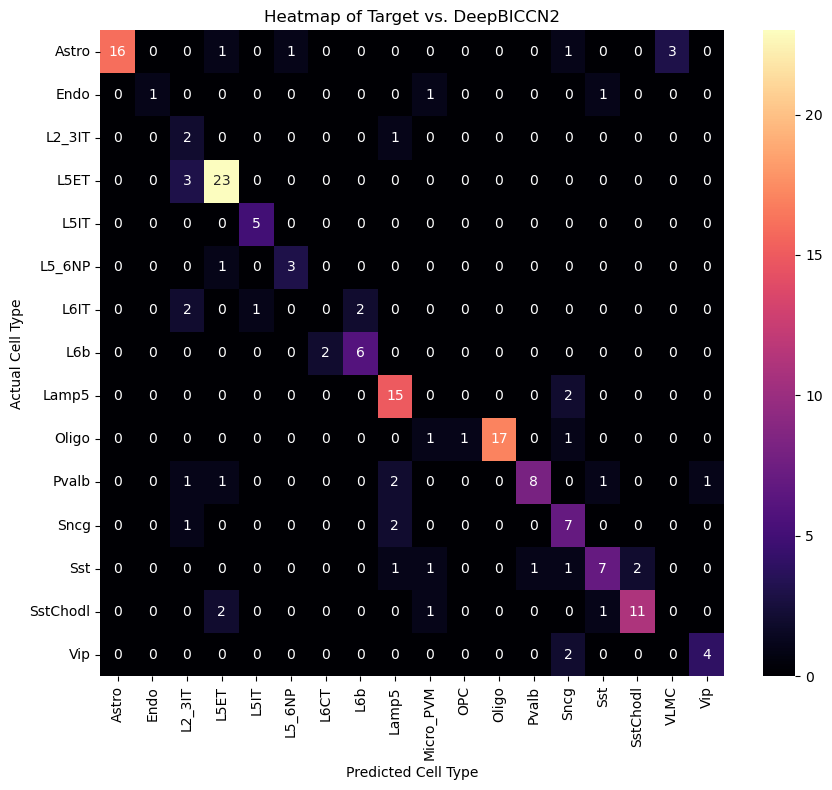

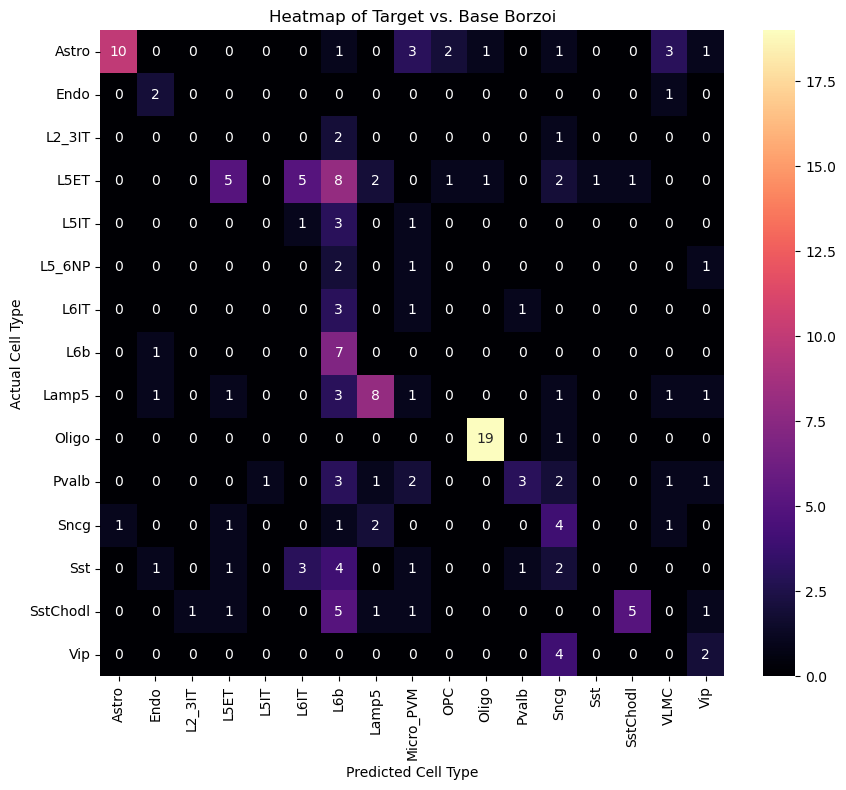

In [29]:
plot_prediction_heatmaps(df, prediction_dict, ['DeepBICCN2'],figsize_scale=9)#, save_file='preds.pdf')
plot_prediction_heatmaps(df, prediction_dict, ['Base Borzoi'],figsize_scale=9)#, save_file='preds.pdf')

In [30]:
performance_df = calculate_performance_metrics(df, prediction_dict, model_names)
performance_df

/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

,accuracy,precision,recall,f1_score
DeepBICCN2,0.730994,0.797486,0.730994,0.749440
Borzoi (double-finetuned),0.725146,0.803615,0.725146,0.742170
Base Borzoi,0.380117,0.524116,0.380117,0.398128


# Complete scoring

Just doing a binary prediction already gives some insights in how well the model works, but it does not give an idea of how strong and specific your predictions were.
Ideally, if an enhancer is only active in one cell type, the model should predict a strong peak only there, and close to zero everywhere else. For this, we will also take the off-target predictions into account. We do this by calculating specificity over all cell types.

In [31]:
score_list = []
for preds in all_preds:
    score_list.append(calculate_specificity(preds))
    
score_names = model_names

In [32]:
# We assign ground truth values based on the enhancer labels.
import numpy as np
import pandas as pd
from tqdm import tqdm

# Initialize ground truth values array
gt_values = np.zeros_like(score_list[0], dtype=int)

# Iterate through DataFrame rows
for index, row in tqdm(df.iterrows(), total=len(df)):
    annots = np.array(classes)
    
    # Get the first and second target cell types
    first_target = row['target_ct']
    second_target = row['second_target_ct']

    # Find indices of the mapped classes in annotations
    idx_1 = np.argwhere(annots == first_target).flatten() if first_target else None
    idx_2 = np.argwhere(annots == second_target).flatten() if second_target else None

    # Assign 1 to the corresponding indices in gt_values
    if idx_1 is not None:
        gt_values[index, idx_1] = 1
    if idx_2 is not None:
        gt_values[index, idx_2] = 1
        

100%|██████████| 171/171 [00:00<00:00, 24683.41it/s]


chr4:123946764-123947415
AiE0453m


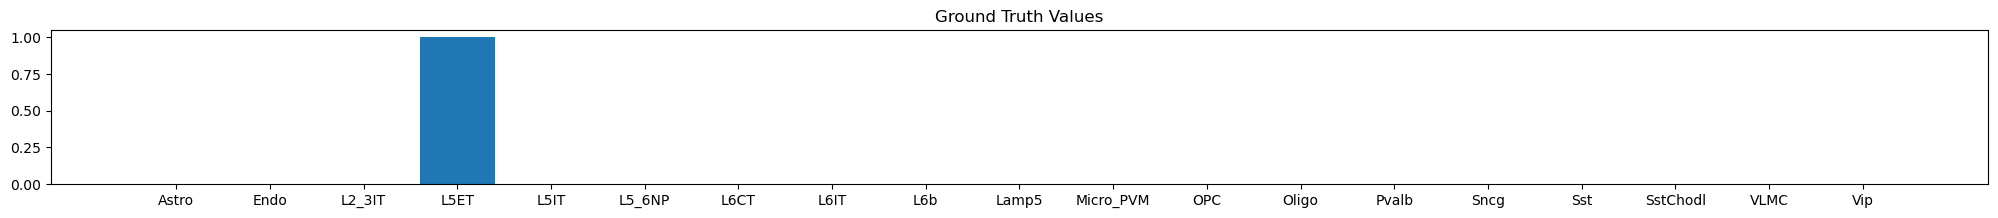

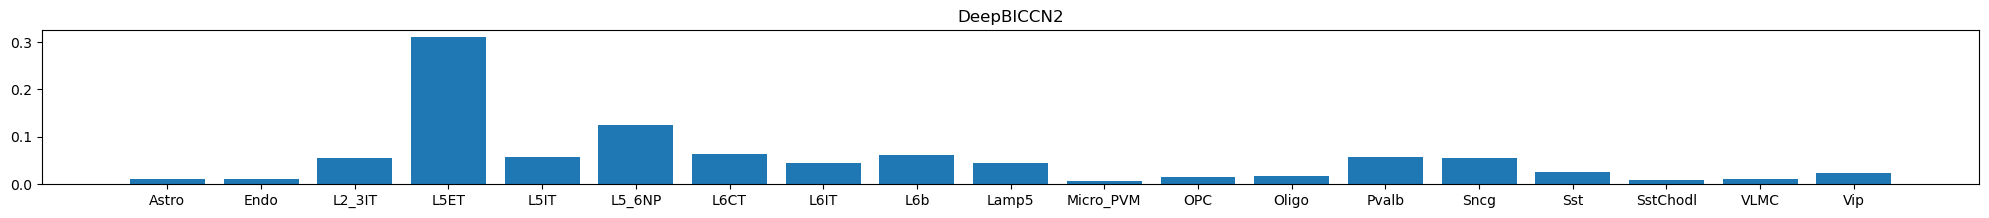

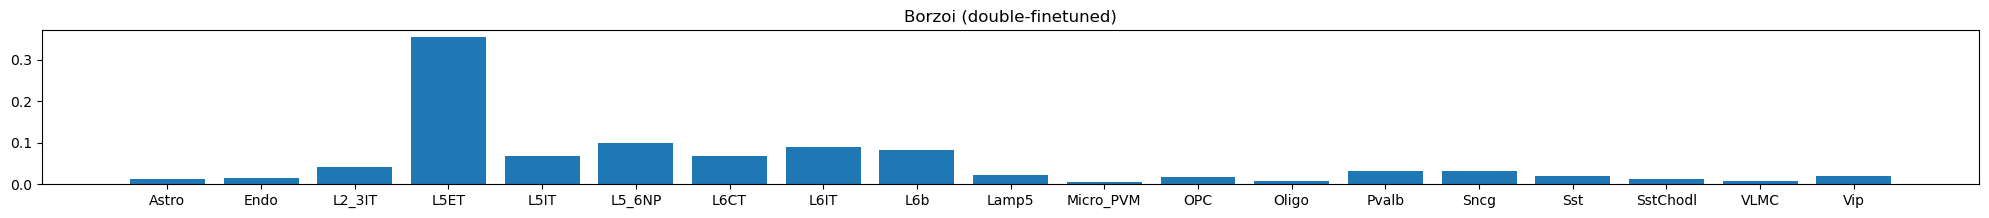

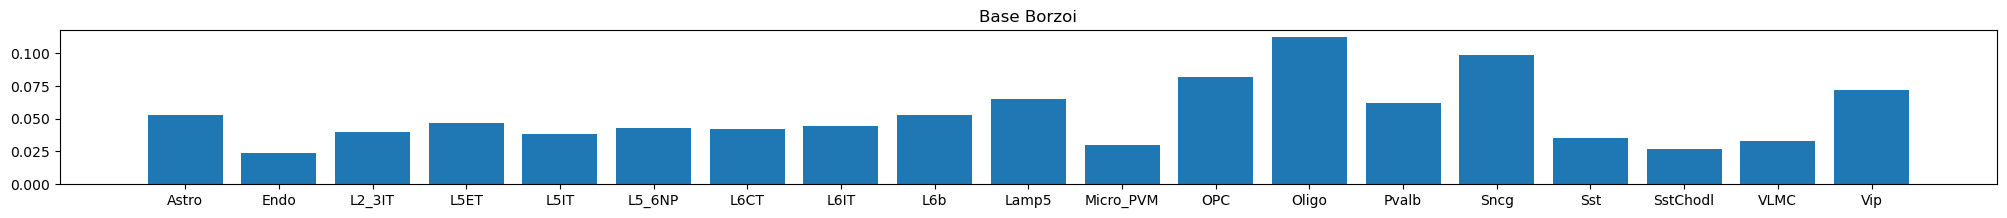

In [39]:
# Example region ground truth (top) and specificity scores (note: not raw predictions!).
index=88
print(df.iloc[index]['name'])
print(df.iloc[index]['enhancerID'])

plot_bar_for_scores(index, classes, gt_values, score_list, scoring_labels=score_names)

## Fig. 5d

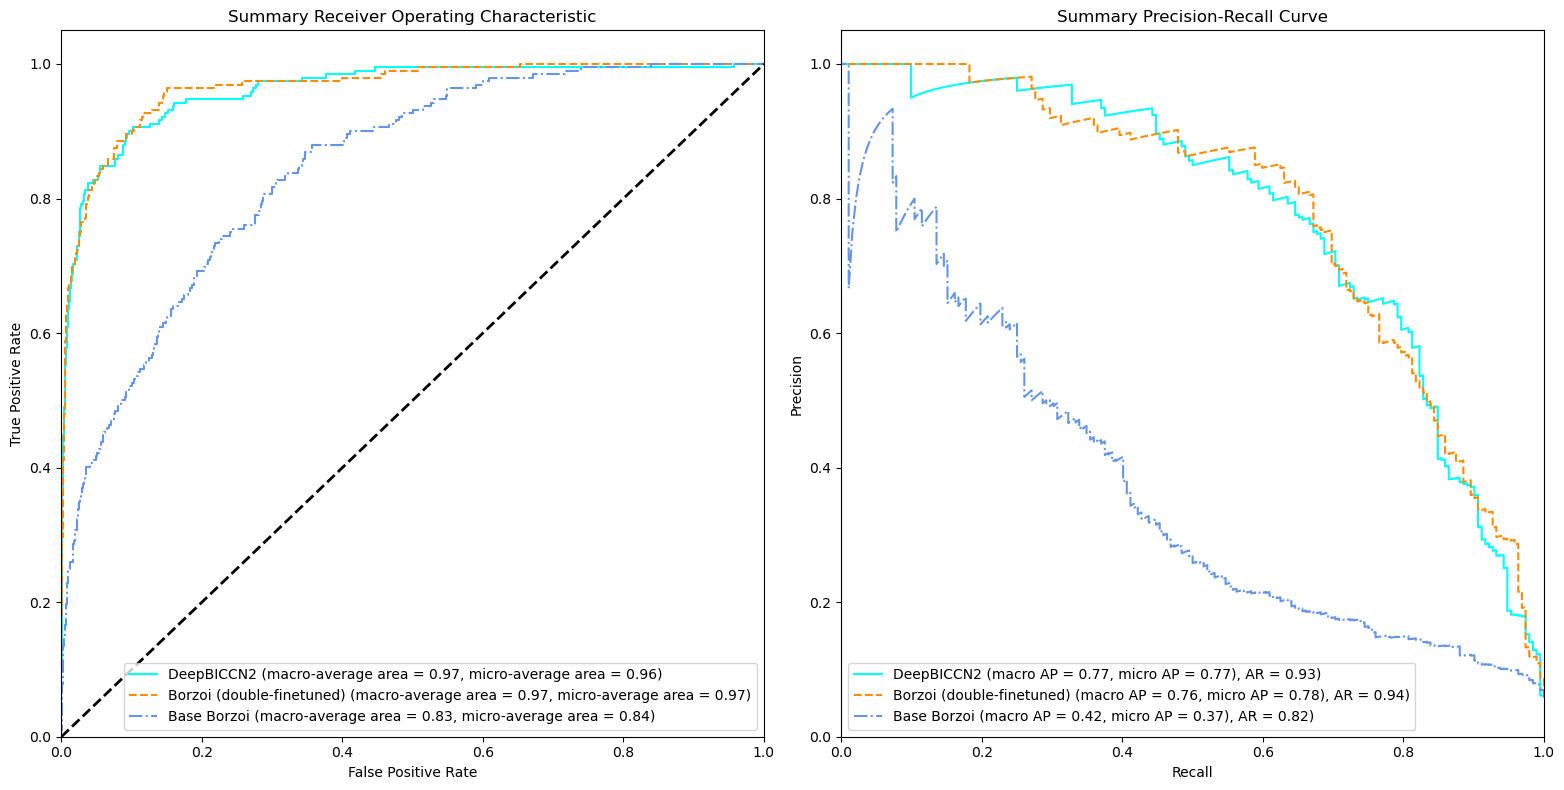

In [41]:
models_data_all = []
for i, score in enumerate(score_list):
    dict1 = {}
    dict1['name']=score_names[i]
    dict1['y_score']= score_list[i]
    dict1['y_true']= gt_values
    models_data_all.append(dict1)

plot_summary_roc_aupr(models_data_all)#, file='scoring.pdf')